# Classifying Buildings Post Hurricane
> Classifying damaged buildings post hurricane to aid in relief measures

# Introduction
The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we classify buildings between damaged and not damaged buildings using the satellite imagery data provided to you.



Team - 
[Akshay Ranjith](https://github.com/akshaypt7), 
[Prerna Mahajan](https://www.linkedin.com/in/dr-prerna-mahajan-85052b67/),
[Vasanth Kumar], 
[Vishal Balaji](https://www.linkedin.com/in/vishal-balaji-121b49137/)

# Data Description

Here we use data from [Geo Satellite sensor](https://www.satimagingcorp.com/satellite-sensors/geoeye-1/) and [Geo Big Data](http://www.urbangeobigdata.it)
to get images of damaged and undamaged buildings from Hurricanes.

The dataset consists of 4 parts:
- Training; 5000 each for damaged and undamaged
- Validation; 1000 each for damaged and undamaged

It consists of 2 test datasets:
- Unbalanced dataset with 8000 damaged and 1000 undamaged images
- Balanced dataset with 1000 each for damaged and undamaged

# Loading data

#### Installing and Importing required libraries

In [ ]:
#importing necessary packages
import keras
import h5py
import PIL.Image
import os, shutil
from keras.models import load_model
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
from keras.regularizers import l2

from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense
from keras import Sequential

from keras import layers
from keras import models

from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Activation, Dense, Dropout, Flatten, BatchNormalization,Reshape,Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import  array_to_img, img_to_array, load_img

from skimage.color import rgb2lab, lab2rgb, rgb2gray

import numpy as np
import os
import random
import matplotlib.pyplot as plt

!pip install PrettyTable
from prettytable import PrettyTable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_damage_dir = '/content/drive/MyDrive/AI_2/project/train_another/damage'
validation_damage_dir = '/content/drive/MyDrive/AI_2/project/validation_another/damage'
unbalanced_test_damage_dir = '/content/drive/MyDrive/AI_2/project/test_another/damage'
test_damage_dir = '/content/drive/MyDrive/AI_2/project/test/damage'

train_nodamage_dir = '/content/drive/MyDrive/AI_2/project/train_another/no_damage'
validation_nodamage_dir = '/content/drive/MyDrive/AI_2/project/validation_another/no_damage'
unbalanced_test_nodamage_dir = '/content/drive/MyDrive/AI_2/project/test_another/no_damage'
test_nodamage_dir = '/content/drive/MyDrive/AI_2/project/test_another/no_damage'

In [ ]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total  test damage images: ',len(os.listdir(test_damage_dir)))
print('total  test_unbalanced_ds damage images: ',len(os.listdir(unbalanced_test_damage_dir)))

print('---')
print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))
print('total  test_unbalanced_ds no damage images: ',len(os.listdir(unbalanced_test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total  test damage images:  1000
total  test_unbalanced_ds damage images:  8000
---
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000
total  test_unbalanced_ds no damage images:  1000


# EDA

Reference - https://www.kaggle.com/yuempark/satellite-images-of-hurricane-damage

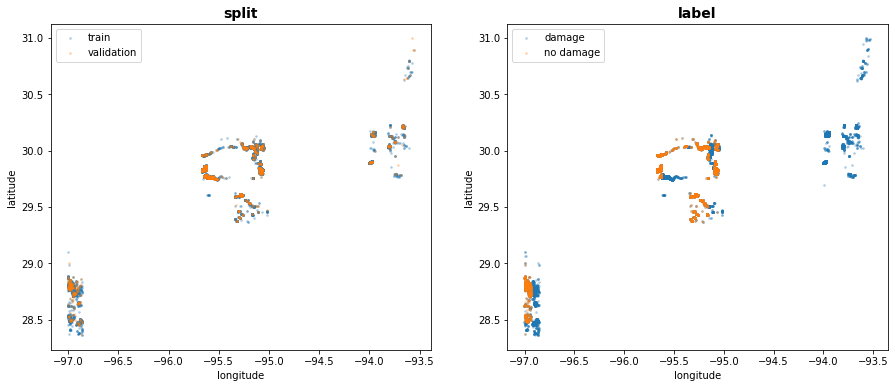

In [ ]:
# Plot to get the distribution of images by their spatial location

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 3
alpha = 0.25

# splitting train, validation and test set
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

# sorting to get the consistant behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

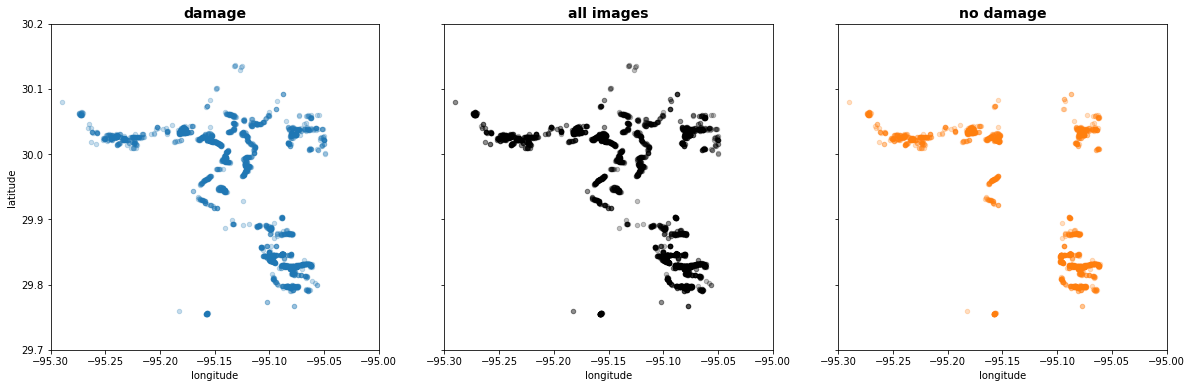

In [ ]:
# To get more information about specific location by focussing on it.

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=14, fontweight='bold')

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=14, fontweight='bold')

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=14, fontweight='bold')

ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[2].set_xlabel('longitude')

ax[0].set_xlim(-95.3,-95)
ax[0].set_ylim(29.7,30.2)

plt.show(fig)

# Modelling

## Baseline Model

Here we create a baseline model based on the pixel similarity

1) We find the avg pixel value for every pixel of the damage_images and no_damage_images. 

2) This will give us two group averages, lets call that "ideal damage_image' and "ideal no_damage image". 

3)Then to classify, an image as damaged or not damaged, we see which of these two ideal_images the test_image is most similar to (distance btw corresponding pixels). 




In [ ]:
# This distance gives us the similarity btw the two images
# We are using absloute distance
def distance(a,b): return np.abs((a-b)).mean((-2,-3)).mean(-1)


#### Loading images into an array

In [ ]:
import cv2
import glob

damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/AI_2/project/train_another/damage/*.jpeg')]
no_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/AI_2/project/train_another/no_damage/*.jpeg')]

# normalizing images
damage_images = np.array(damage_images)
damage_images = damage_images/255.0
print(damage_images.shape)
no_damage_images = np.array(no_damage_images)
no_damage_images = no_damage_images/255.0
print(no_damage_images.shape)

(5000, 128, 128, 3)
(5000, 128, 128, 3)


In [ ]:
import cv2
import glob
valid_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/AI_2/project/validation_another/damage/*.jpeg')]
valid_no_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/AI_2/project/validation_another/no_damage/*.jpeg')]

valid_damage_images = np.array(valid_damage_images)
valid_damage_images = valid_damage_images/255.0
valid_no_damage_images = np.array(valid_no_damage_images)
valid_no_damage_images = valid_no_damage_images/255.0

#### Creating the Ideal damage image

In [ ]:
# mean damage image

mean_damage_image = damage_images.mean(0)
mean_no_damage_image = no_damage_images.mean(0)
mean_damage_image.shape

(128, 128, 3)

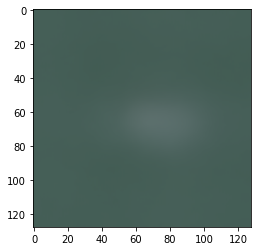

In [ ]:
# plotting ideal damage image
plt.imshow(mean_damage_image)

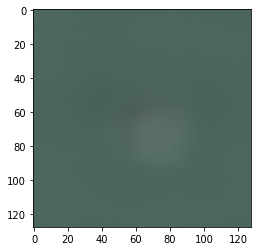

In [ ]:
# plotting ideal no damage image
plt.imshow(mean_no_damage_image)

In [ ]:
# distance btw the ideal_damage_image and first 10 damage images.
distance(mean_damage_image,damage_images[0:10])

array([0.10244854, 0.08909787, 0.10564563, 0.15100061, 0.07896621,
       0.27601056, 0.0813075 , 0.06772321, 0.04691103, 0.11486665])

In [ ]:
# This function to see which of the two ideal_images the test image is closer to
def is_damage(x) : return distance(x,mean_damage_image) < distance(x,mean_no_damage_image)

In [ ]:
result_array = np.asarray(is_damage(valid_damage_images), dtype = np.float64 ) # converting the boolean values into 1's and 0's
accuracy_damage = result_array.mean()
print(f'Accuracy for predicting damage images {accuracy_damage}')
result1_array = np.asarray((1-is_damage(valid_no_damage_images)), dtype = np.float64 )
accuracy_no_damage = result1_array.mean()
print(f'Accuracy for predicting damage images {accuracy_no_damage}')

Accuracy for predicting damage images 0.731
Accuracy for predicting damage images 0.435


In [ ]:
final_accuracy = (accuracy_damage+accuracy_no_damage)/2
print(f'The accuracy of the baseline model based on pixel similarity is {final_accuracy}')

The accuracy of the baseline model based on pixel similarity is 0.583


## CNN Model from Scratch

We are using recall_m , precision and f1_score as metrics since we have unbalanced dataset.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential(name = 'model_from_scratch')
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


In [ ]:

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy',precision_m,recall_m,f1_m])

In [ ]:


#normalize the image pixel value to be between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    '/content/drive/MyDrive/AI_2/project/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(
                    '/content/drive/MyDrive/AI_2/project/validation_another',
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
                    '/content/drive/MyDrive/AI_2/project/test',
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

test_generator_unbalanced = test_datagen.flow_from_directory(
                    '/content/drive/MyDrive/AI_2/project/test_another',
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_validation = validation_generator.n//validation_generator.batch_size

In [ ]:
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
         steps_per_epoch=step_size_train,
        validation_steps= step_size_validation
        )

Epoch 1/10
312/312 [==============================] - 389s 1s/step - loss: 0.3919 - accuracy: 0.8212 - precision_m: 0.8252 - recall_m: 0.8505 - f1_m: 0.8189 - val_loss: 0.2085 - val_accuracy: 0.9037 - val_precision_m: 0.8753 - val_recall_m: 0.9409 - val_f1_m: 0.9053
Epoch 2/10
312/312 [==============================] - 38s 123ms/step - loss: 0.1959 - accuracy: 0.9206 - precision_m: 0.9295 - recall_m: 0.9155 - f1_m: 0.9188 - val_loss: 0.1594 - val_accuracy: 0.9405 - val_precision_m: 0.9233 - val_recall_m: 0.9583 - val_f1_m: 0.9388
Epoch 3/10
312/312 [==============================] - 39s 124ms/step - loss: 0.1518 - accuracy: 0.9409 - precision_m: 0.9470 - recall_m: 0.9360 - f1_m: 0.9387 - val_loss: 0.1357 - val_accuracy: 0.9451 - val_precision_m: 0.9387 - val_recall_m: 0.9495 - val_f1_m: 0.9427
Epoch 4/10
312/312 [==============================] - 39s 125ms/step - loss: 0.1383 - accuracy: 0.9462 - precision_m: 0.9494 - recall_m: 0.9445 - f1_m: 0.9442 - val_loss: 0.2139 - val_accuracy: 0

In [ ]:
# Save the weights
# model.save_weights('/content/drive/MyDrive/AI_2/project')

In [ ]:
model.load_weights('/content/drive/MyDrive/AI_2/project')

#### Training Vs Validation loss & Accuracy

In [ ]:
history.history['val_loss'],history.history['loss']


([0.14701536297798157], [0.028449108824133873])

Text(0.5, 1.0, 'Accuracy')

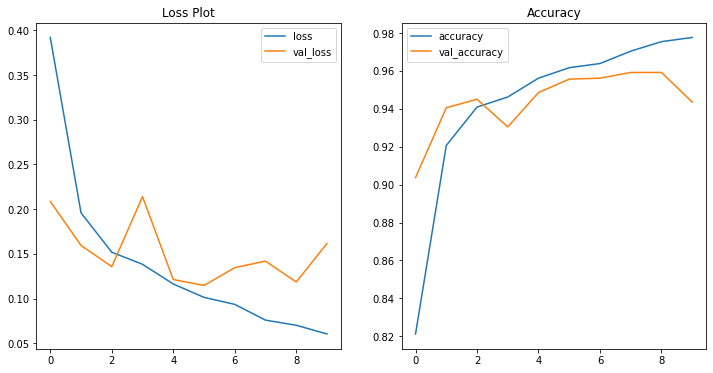

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_title('Loss Plot')

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')

In [ ]:

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy',precision_m,recall_m,f1_m])

In [ ]:
model.evaluate(test_generator)

63/63 [==============================] - 185s 3s/step - loss: 0.0755 - accuracy: 0.9805 - precision_m: 0.9839 - recall_m: 0.9780 - f1_m: 0.9804


[0.0754949077963829,
 0.9804999828338623,
 0.9838618040084839,
 0.9779601097106934,
 0.9803661108016968]

In [ ]:
model.evaluate(test_generator_unbalanced)

282/282 [==============================] - 1690s 6s/step - loss: 0.0801 - accuracy: 0.9754 - precision_m: 0.8357 - recall_m: 0.9337 - f1_m: 0.8700


[0.08007495850324631,
 0.9754444360733032,
 0.8357259035110474,
 0.9336668252944946,
 0.8699988126754761]

In [ ]:
model.evaluate(test_generator_unbalanced)

## Transfer Learning

### DenseNet Model

We tried Transfer Learning using DenseNet201 model where we get accuracy around 0.964, we also tried vgg16 model, it also gave similar kind of accuracy.96(training) and .964 on balanced test set

In [ ]:
#Transfer Learning using DenseNet modelby omitting Top Layers

base_model=DenseNet201(input_shape=[128,128,3],weights='imagenet',include_top=False) 

74850304/74836368 [==============================] - 2s 0us/step


In [ ]:
x=base_model.output # Taken Base Densenet Model
base_model.trainable=False # Freezed the earlier layers
#Used Global AveragePooling, Relu Activation and Final Output Layer with sigmoid activation function
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
preds=Dense(1,activation='sigmoid')(x) 
model_densenet=Model(inputs=[base_model.input],outputs=[preds]) #specify the inputs and outputs

In [ ]:
model_densenet.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=val_generator.n//val_generator.batch_size 

history_densenet=model_densenet.fit(train_generator,validation_data=val_generator,steps_per_epoch=step_size_train,validation_steps=step_size_validation,epochs=10)

Epoch 1/10
312/312 [==============================] - 1390s 4s/step - loss: 0.3013 - accuracy: 0.8781 - val_loss: 0.1843 - val_accuracy: 0.9209
Epoch 2/10
312/312 [==============================] - 92s 293ms/step - loss: 0.2001 - accuracy: 0.9171 - val_loss: 0.1463 - val_accuracy: 0.9415
Epoch 3/10
312/312 [==============================] - 91s 293ms/step - loss: 0.1740 - accuracy: 0.9288 - val_loss: 0.1242 - val_accuracy: 0.9491
Epoch 4/10
312/312 [==============================] - 93s 297ms/step - loss: 0.1544 - accuracy: 0.9356 - val_loss: 0.1330 - val_accuracy: 0.9441
Epoch 5/10
312/312 [==============================] - 94s 299ms/step - loss: 0.1513 - accuracy: 0.9379 - val_loss: 0.1181 - val_accuracy: 0.9521
Epoch 6/10
312/312 [==============================] - 92s 293ms/step - loss: 0.1415 - accuracy: 0.9405 - val_loss: 0.1340 - val_accuracy: 0.9446
Epoch 7/10
312/312 [==============================] - 92s 295ms/step - loss: 0.1315 - accuracy: 0.9461 - val_loss: 0.1211 - val_acc

In [ ]:
# Save the weights
#model_densenet.save_weights('/content/drive/MyDrive/project')

In [ ]:
model_densenet.load_weights('/content/drive/MyDrive/project')

In [ ]:
model_densenet.evaluate(val_generator,steps=step_size_validation)

62/62 [==============================] - 10s 156ms/step - loss: 0.1048 - accuracy: 0.9546


[0.10476627945899963, 0.9546371102333069]

In [ ]:
test1_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test1_generator=test1_datagen.flow_from_directory(test1_dir,target_size=(128,128),class_mode='binary',shuffle=True)
step_size_test1=test1_generator.n//test1_generator.batch_size 

Found 9000 images belonging to 2 classes.


In [ ]:
model_densenet.evaluate(test1_generator)#,steps=step_size_test1)

282/282 [==============================] - 55s 194ms/step - loss: 0.0912 - accuracy: 0.9620


[0.09124457836151123, 0.9620000123977661]

In [ ]:
test2_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test2_generator=test2_datagen.flow_from_directory(test2_dir,target_size=(128,128),class_mode='binary',shuffle=True)
step_size_test2=test2_generator.n//test2_generator.batch_size 

Found 2000 images belonging to 2 classes.


In [ ]:
model_densenet.evaluate(test2_generator,steps=step_size_test2)

62/62 [==============================] - 10s 153ms/step - loss: 0.1014 - accuracy: 0.9597


[0.10139621794223785, 0.9596773982048035]

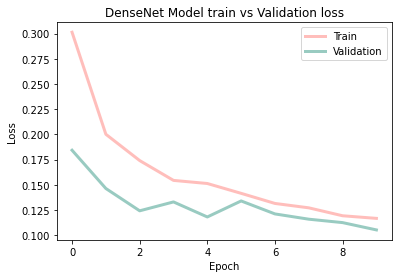

In [ ]:
# Plot the loss 
plt.plot(history_densenet.history['loss'], color='#FF7E79',linewidth=3, alpha=0.5)
plt.plot(history_densenet.history['val_loss'], color='#007D66', linewidth=3, alpha=0.4)
plt.title('DenseNet Model train vs Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

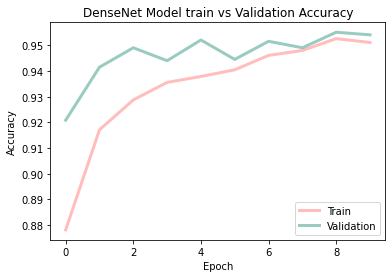

In [ ]:
# Plot the accuracy
plt.plot(history_densenet.history['accuracy'], color='#FF7E79',linewidth=3, alpha=0.5)
plt.plot(history_densenet.history['val_accuracy'], color='#007D66', linewidth=3, alpha=0.4)
plt.title('DenseNet Model train vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### VGG16 Model

In [ ]:
IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
pretrained_model=tf.keras.applications.vgg16.VGG16(input_shape=[224,224,3],weights='imagenet',include_top=False) 

In [ ]:
x=pretrained_model.output
pretrained_model.trainable=False
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
preds=Dense(1,activation='sigmoid')(x) 
model_vggnet=Model(inputs=[pretrained_model.input],outputs=[preds]) #specify the inputs and outputs

In [ ]:
model_vggnet.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=val_generator.n//val_generator.batch_size 
history_vggnet=model_vggnet.fit(train_generator,validation_data=val_generator,steps_per_epoch=step_size_train,validation_steps=step_size_validation,epochs=10)

Epoch 1/10
312/312 [==============================] - 201s 606ms/step - loss: 0.2551 - accuracy: 0.8939 - val_loss: 0.1635 - val_accuracy: 0.9320
Epoch 2/10
312/312 [==============================] - 183s 586ms/step - loss: 0.1720 - accuracy: 0.9317 - val_loss: 0.1726 - val_accuracy: 0.9345
Epoch 3/10
312/312 [==============================] - 183s 587ms/step - loss: 0.1507 - accuracy: 0.9386 - val_loss: 0.1126 - val_accuracy: 0.9506
Epoch 4/10
312/312 [==============================] - 183s 587ms/step - loss: 0.1339 - accuracy: 0.9460 - val_loss: 0.1109 - val_accuracy: 0.9516
Epoch 5/10
312/312 [==============================] - 184s 588ms/step - loss: 0.1243 - accuracy: 0.9487 - val_loss: 0.0947 - val_accuracy: 0.9627
Epoch 6/10
312/312 [==============================] - 183s 586ms/step - loss: 0.1170 - accuracy: 0.9505 - val_loss: 0.0894 - val_accuracy: 0.9617
Epoch 7/10
312/312 [==============================] - 183s 587ms/step - loss: 0.1119 - accuracy: 0.9552 - val_loss: 0.1060 -

In [ ]:
model_vggnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_vggnet.evaluate(val_generator,steps=step_size_validation)

62/62 [==============================] - 16s 248ms/step - loss: 0.0894 - accuracy: 0.9612


[0.08941652625799179, 0.9611895084381104]

In [ ]:
test1_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test1_generator=test1_datagen.flow_from_directory(test1_dir,target_size=(224,224),class_mode='binary',shuffle=True)
step_size_test1=test1_generator.n//test1_generator.batch_size 

Found 9000 images belonging to 2 classes.


In [ ]:
model_vggnet.evaluate(test1_generator)#,steps=step_size_test1)

282/282 [==============================] - 73s 258ms/step - loss: 0.0947 - accuracy: 0.9608


[0.0946614146232605, 0.960777759552002]

In [ ]:
test2_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
test2_generator=test2_datagen.flow_from_directory(test2_dir,target_size=(224,224),class_mode='binary',shuffle=True)
step_size_test2=test2_generator.n//test2_generator.batch_size 

Found 2000 images belonging to 2 classes.


In [ ]:
model_vggnet.evaluate(test2_generator,steps=step_size_test2)

62/62 [==============================] - 16s 248ms/step - loss: 0.0879 - accuracy: 0.9642


[0.0879480242729187, 0.9642137289047241]

# Feature and Saliency Maps

Here we are doing feature and saliency maps for the DenseNet model

## Featue Maps

In [ ]:
#Function to Plot Feature maps
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze())
#     axbig.set_title(f'{cifar10dict[np.argmax(model.predict(img))]}')
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',size=16,y=1.05);

In [ ]:
#Get feature map model  for a particular layer i.e 2  layerin this case
layer_names = [layer.name for layer in model_densenet.layers]
layer_outputs = [layer.output for layer in model_densenet.layers]
#select an intermediate convolutional layer for feature mapsi.e 2 layer
layer2_output = model_densenet.layers[2].output
feature_map_model =  Model(inputs=model_densenet.input, outputs=layer2_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


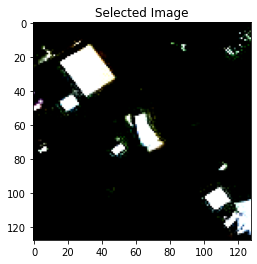

In [ ]:
x,y = test1_generator.next()
image = x[10]
plt.imshow(image)
plt.title("Selected Image")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


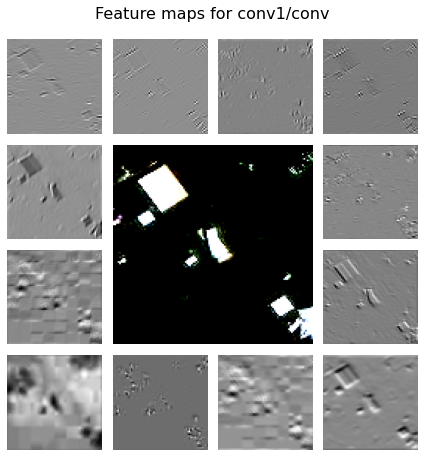

In [ ]:
img = x[10].reshape(1,128,128,3)
#get the activation map for the selected image
feature_maps=feature_map_model.predict(img)
#use plot_featuremaps() function to plot the image and its activations
plot_featuremaps(img,feature_maps,[model_densenet.layers[2].name])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


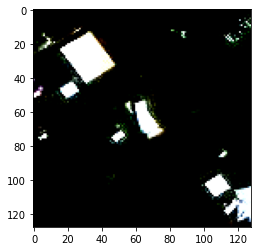

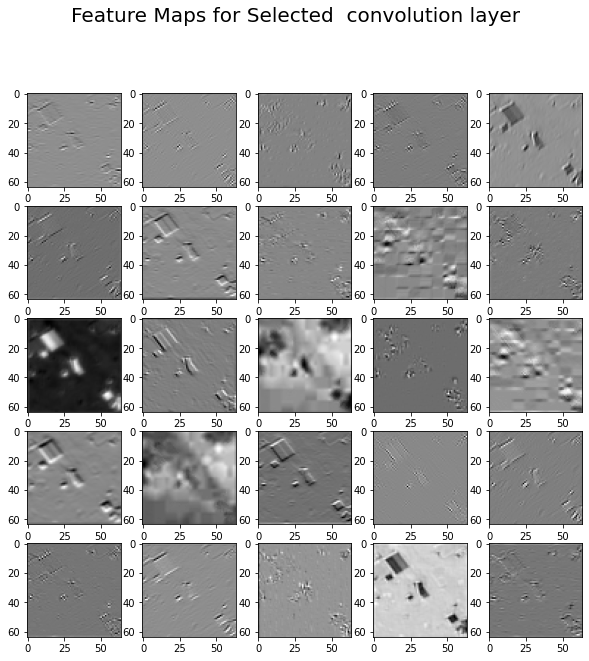

In [ ]:
# Alternate representation of the same selected image and its activations in a grid of 3*3
# Use a sample image from the test set to visualize the feature maps
feature_map_model =  Model(inputs=model_densenet.input, outputs=layer2_output)
# Use a sample image from the test set to visualize the feature maps
#img = test_images[img_idx].reshape(1,128,128,3)
#plot the image
image = x[10]
plt.imshow(image)
plt.show()
feature_maps = feature_map_model.predict(img) 
# Plot the activations in a grid of 5*5 using cmap="gray"
fig, axs = plt.subplots(ncols=5, nrows=5,figsize = (10,10))
for i, axis in enumerate(axs.ravel()):
  axis.imshow(feature_maps.squeeze()[:,:,i], cmap='gray')
fig.suptitle('Feature Maps for Selected  convolution layer',fontsize=20, y=1.00);   

In [ ]:
import cv2
import glob

damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/project/train_another/damage/*.jpeg')]
no_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/project/train_another/no_damage/*.jpeg')]

In [ ]:
damage_images[10].shape

(128, 128, 3)

In [ ]:
damage_images = np.array(damage_images)
damage_images = damage_images/255.0
print(damage_images.shape)
no_damage_images = np.array(no_damage_images)
no_damage_images = no_damage_images/255.0
print(no_damage_images.shape)

(5000, 128, 128, 3)
(5000, 128, 128, 3)


In [ ]:
valid_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/project/validation_another/damage/*.jpeg')]
valid_no_damage_images = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/project/validation_another/no_damage/*.jpeg')]

In [ ]:
valid_damage_images = np.array(valid_damage_images)
valid_damage_images = valid_damage_images/255.0
valid_no_damage_images = np.array(valid_no_damage_images)
valid_no_damage_images = valid_no_damage_images/255.0

## Saliency Maps and GradCAM for the selected Image(Both Damage and no-Damage)

In [ ]:
img = damage_images[20].reshape(1,128,128,3)
img.shape

(1, 128, 128, 3)

In [ ]:
# your code here
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

Text(0.5, 1.0, 'GradCAM')

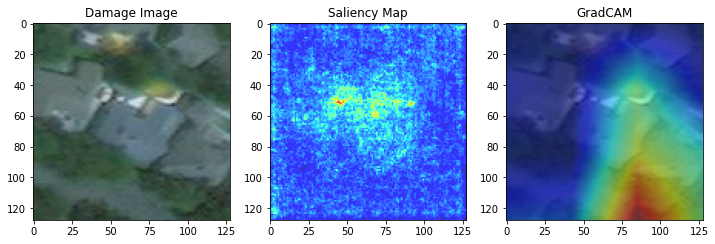

In [ ]:
# Saliency Map Grad-CAM for Damage Image
#plot Original Image, Saliency Map, GradCAM. 
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Original
axes[0].imshow(damage_images[20])
axes[0].set_title("Damage Image")

# Sailency map (Smooth grad)
y_pred = model_densenet.predict(img)
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# The `output` variable refer to the output of the model,
loss = lambda output: tf.keras.backend.mean(output[:, class_idxs_sorted[0]])
saliency = Saliency(model_densenet, model_modifier=model_modifier, clone=False)
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss, img,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

axes[1].imshow(tf.squeeze(saliency_map), cmap='jet',alpha=0.8)
axes[1].set_title("Saliency Map")

# Grad CAM
gradcam = Gradcam(model_densenet, model_modifier=model_modifier, clone=False)
cam = gradcam(loss, img, penultimate_layer=-1) # model.layers number
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
#test_img= x[10]
axes[2].imshow(damage_images[20])
axes[2].imshow(tf.squeeze(heatmap), cmap='jet', alpha=0.5)
axes[2].set_title("GradCAM")

In [ ]:
#No-Damage Image
img = no_damage_images[30].reshape(1,128,128,3)
img.shape

(1, 128, 128, 3)

Text(0.5, 1.0, 'GradCAM')

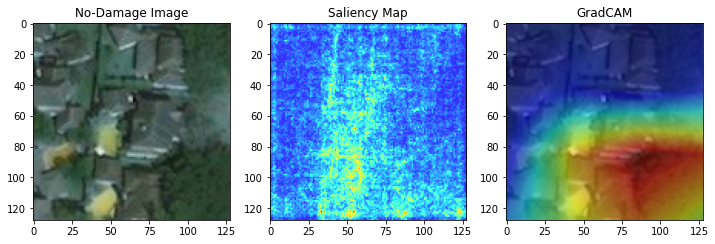

In [ ]:
# Saliency Map Grad-CAM for No-Damage Image
#plot Original Image, Saliency Map, GradCAM. 
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Original
axes[0].imshow(no_damage_images[30])
axes[0].set_title("No-Damage Image")

# Sailency map (Smooth grad)
y_pred = model_densenet.predict(img)
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# The `output` variable refer to the output of the model,
loss = lambda output: tf.keras.backend.mean(output[:, class_idxs_sorted[0]])
saliency = Saliency(model_densenet, model_modifier=model_modifier, clone=False)
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss, img,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

axes[1].imshow(tf.squeeze(saliency_map), cmap='jet',alpha=0.8)
axes[1].set_title("Saliency Map")

# Grad CAM
gradcam = Gradcam(model_densenet, model_modifier=model_modifier, clone=False)
cam = gradcam(loss, img, penultimate_layer=-1) # model.layers number
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
#test_img= x[10]
axes[2].imshow(no_damage_images[30])
axes[2].imshow(tf.squeeze(heatmap), cmap='jet', alpha=0.5)
axes[2].set_title("GradCAM")

# Results of All The Models Together

In [ ]:
model_comparison = PrettyTable()
model_comparison.field_names = ["Model", "Accuracy - Balanced Test","Accuracy - Unbalanced Test","F1-score - Balanced Test set","F1-score - Unbalanced Test Set"]
model_comparison.add_row(["Baseline Model", 0.58,'--' ,'---','----'])
model_comparison.add_row(["CNN from Scratch", 0.98, 0.86,.98,.87 ])
model_comparison.add_row(["Transfer Learning from DenseNet", 0.96,0.95,.95 ,.80])
model_comparison.add_row(["Transfer Learning from VGG16", 0.96,.94,.95 ,.76])

print(model_comparison)

+---------------------------------+--------------------------+----------------------------+------------------------------+--------------------------------+
|              Model              | Accuracy - Balanced Test | Accuracy - Unbalanced Test | F1-score - Balanced Test set | F1-score - Unbalanced Test Set |
+---------------------------------+--------------------------+----------------------------+------------------------------+--------------------------------+
|          Baseline Model         |           0.58           |             --             |             ---              |              ----              |
|         CNN from Scratch        |           0.98           |            0.86            |             0.98             |              0.87              |
| Transfer Learning from DenseNet |           0.96           |            0.95            |             0.95             |              0.8               |
|   Transfer Learning from VGG16  |           0.96           |  

# Image Segmentation - using K-means clustering

In [ ]:
damage_images[0].shape

(150, 150, 3)

In [ ]:
image_1 = damage_images[9]

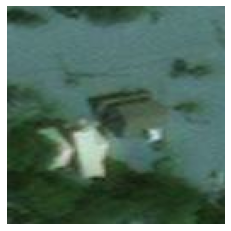

In [ ]:
plt.imshow(image_1)
plt.axis('off');

For clustering we need to convert the image into two dimensions

In [ ]:

image_1.shape


(128, 128, 3)

In [ ]:
image_1_2d = np.array(image_1).reshape(image_1.shape[0]*image_1.shape[1],image_1.shape[2])

In [ ]:
image_1_2d.shape

(16384, 3)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(image_1_2d)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

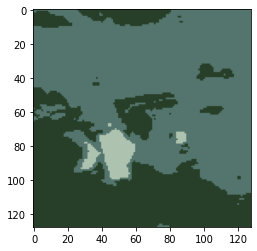

In [ ]:
cluster_pic = pic2show.reshape(image_1.shape[0], image_1.shape[1], image_1.shape[2])
plt.imshow(cluster_pic)

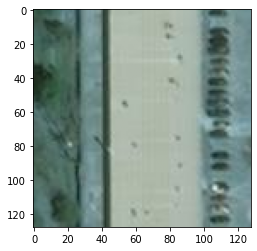

In [ ]:
not_damaged_image = no_damage_images[0]
plt.imshow(not_damaged_image)

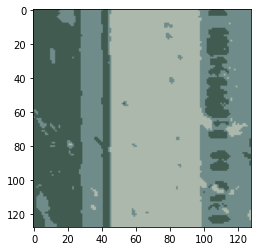

In [ ]:

not_damaged_image_2d = np.array(not_damaged_image).reshape(not_damaged_image.shape[0]*not_damaged_image.shape[1],not_damaged_image.shape[2])
kmeans = KMeans(n_clusters=3, random_state=0).fit(not_damaged_image_2d)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(not_damaged_image.shape[0], not_damaged_image.shape[1], not_damaged_image.shape[2])
plt.imshow(cluster_pic)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.io import imread, imshow
from sklearn.cluster import KMeans

In [ ]:
not_damaged_image = no_damage_images[0]

In [ ]:
damage_image = damage_images[9]

In [ ]:
def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
    return df
df_damage_image = image_to_pandas(damage_image)
df_damage_image.head(5)

,Red_Channel,Green_Channel,Blue_Channel
0,0.305882,0.431373,0.356863
1,0.305882,0.431373,0.356863
2,0.298039,0.423529,0.349020
3,0.278431,0.403922,0.329412
4,0.258824,0.384314,0.317647


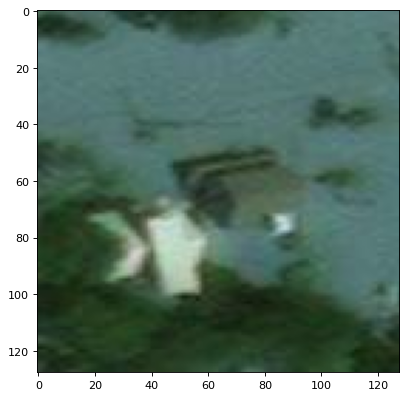

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(damage_image)

##### Image segmentation on Damaged Image

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


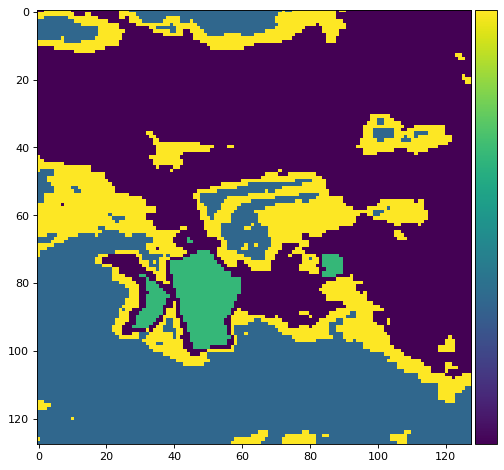

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
kmeans = KMeans(n_clusters=  4, random_state = 42).fit(df_damage_image)
result = kmeans.labels_.reshape(damage_image.shape[0],damage_image.shape[1])
imshow(result, cmap='viridis')
plt.axis('off')
plt.show()

The image is clustered into 4 distinct regions. Let us visualize each region separately

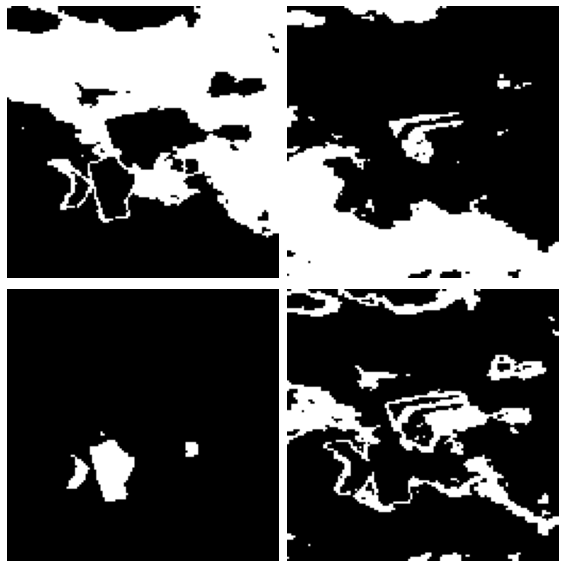

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8, 8))
for n, ax in enumerate(axes.flatten()):
    ax.imshow(result==[n], cmap='gray');
    ax.set_axis_off()
    
fig.tight_layout()

##### Image segmentation on not_damaged image

In [ ]:
not_damaged_image = no_damage_images[2]

In [ ]:
df_not_damaged_image = image_to_pandas(not_damaged_image)
df_not_damaged_image.head(5)

,Red_Channel,Green_Channel,Blue_Channel
0,0.513725,0.631373,0.580392
1,0.521569,0.639216,0.588235
2,0.513725,0.631373,0.580392
3,0.494118,0.611765,0.560784
4,0.498039,0.607843,0.556863


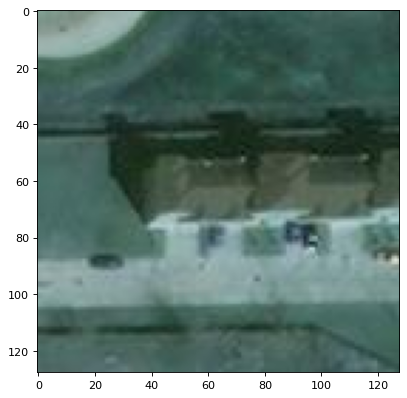

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(not_damaged_image)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


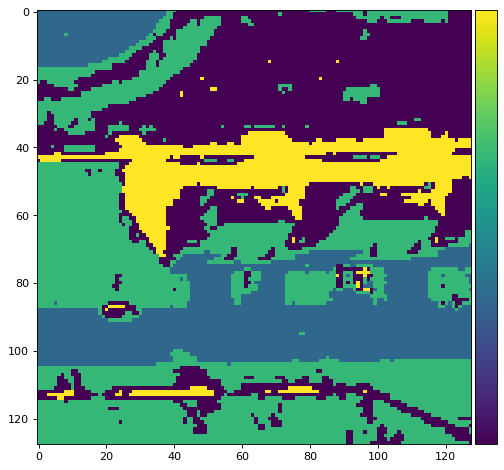

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
kmeans = KMeans(n_clusters=  4, random_state = 42).fit(df_not_damaged_image)
result = kmeans.labels_.reshape(not_damaged_image.shape[0],not_damaged_image.shape[1])
imshow(result, cmap='viridis')
plt.axis('off')
plt.show()

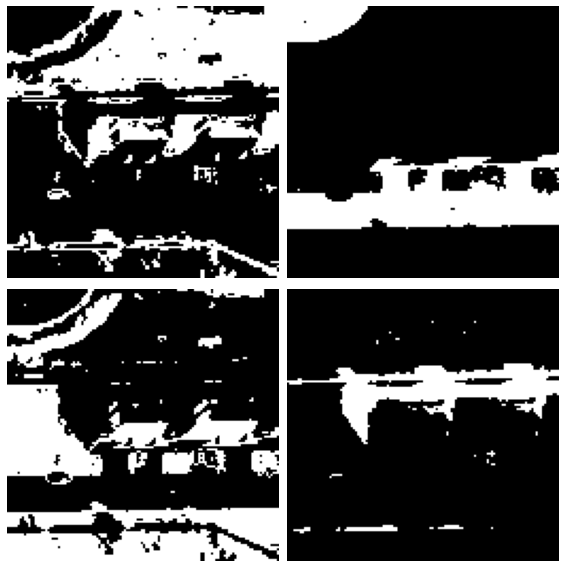

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8, 8))
for n, ax in enumerate(axes.flatten()):
    ax.imshow(result==[n], cmap='gray');
    ax.set_axis_off()
    
fig.tight_layout()

# Auto Encoders

We are creating an Encoder which takes a color_image of the satellite and return a gray_scale image.



(128, 128, 3)


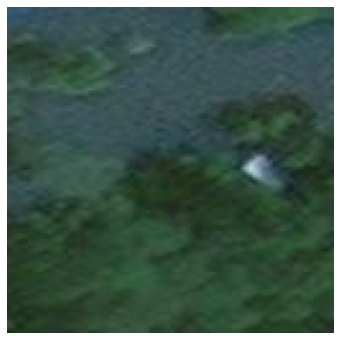

In [ ]:
# The X labels
image = damage_images[1]
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off');
print(image.shape)

In [ ]:
# create the x and y labels. 
X =  [rgb2lab(image) for image in damage_images ] # colored images
y =  [rgb2lab(image)[:,:,0] for image in damage_images ] # black and white


In [ ]:

X = np.array(X)
y = np.array(y)

X.shape, y.shape # X is the color image in lab format and y is in gray_scale format

((5000, 128, 128, 3), (5000, 128, 128))

In [ ]:
# create the xtest and ytest labels. 
x_test =  [rgb2lab(image) for image in valid_damage_images ] # colored images
y_test =  [rgb2lab(image)[:,:,0] for image in valid_damage_images ] # black and white


In [ ]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# Your code here 
model = Sequential(name='Auto-gray-scale')


model.add(Conv2D(8,3,strides=(2,2),activation='relu',input_shape=(128,128,3),padding='same')) # we are passing in colored images
model.add(Conv2D(8,3,activation='relu',padding='same'))
model.add(Conv2D(16,3,activation='relu',padding='same'))
model.add(Conv2D(16,3,strides=(2,2),activation='relu',padding='same'))
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(Conv2D(32,3,strides=(2,2),activation='relu',padding='same'))

model.add(UpSampling2D(size=(2, 2)))

model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(UpSampling2D(size=(2, 2),interpolation="bilinear"))
# model.add(Conv2D(32,3,activation='relu'))
model.add(Conv2D(16,3,activation='relu',padding='same'))
# model.add(Conv2D(16,3,activation='relu'))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(1,3,activation='relu',padding='same')) # since we need only one channel we need to pass number of filter =1


model.summary()

Model: "Auto-gray-scale"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 32)   

In [ ]:
model.compile(loss=tf.keras.metrics.mean_squared_error,optimizer='adam')

In [ ]:
y_new = np.expand_dims(y,axis=-1) # we need to change the dimension of y so that we can use it for training

In [ ]:
y_test_new = np.expand_dims(y_test,axis=-1)
y_test_new.shape

In [ ]:
batch_size = 32
history = model.fit(
        X,y_new,
       validation_split=0.2, steps_per_epoch = X[0].shape[0]/batch_size,
        epochs=20
        )

Epoch 1/20
4/4 [==============================] - 5s 1s/step - loss: 77.0828 - val_loss: 69.5025
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 66.2613 - val_loss: 61.9128
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 57.9326 - val_loss: 54.7187
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 51.3881 - val_loss: 50.4604
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 47.0463 - val_loss: 45.9837
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 43.3608 - val_loss: 42.6499
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 40.4375 - val_loss: 39.4496
Epoch 8/20
4/4 [==============================] - 5s 1s/step - loss: 37.6762 - val_loss: 36.4601
Epoch 9/20
4/4 [==============================] - 5s 1s/step - loss: 35.0882 - val_loss: 34.0332
Epoch 10/20
4/4 [==============================] - 5s 1s/step - loss: 32.8062 - val_loss: 32.0686
Epoch 11/20
4/4 [============

In [ ]:
# Save the weights
# model.save_weights('/content/drive/MyDrive/AI_2/project/encoder')

In [ ]:
model.load_weights('/content/drive/MyDrive/AI_2/project/encoder')

##### Looking at the prediction

In [ ]:
test_image = np.expand_dims(X[5],axis=0)
test_image.shape

(1, 128, 128, 3)

(-0.5, 127.5, 127.5, -0.5)

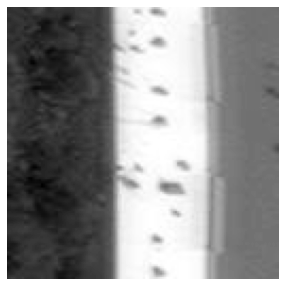

In [ ]:
# target_variable
y[5].shape
plt.figure(figsize=(5,5))
plt.imshow(y[5],cmap='gray')
plt.axis('off')

In [ ]:
pred = model.predict(test_image)
pred.shape

(1, 128, 128, 1)

In [ ]:
# changing the shape
pred_new = pred.reshape(128,128)
pred_new.shape

(128, 128)

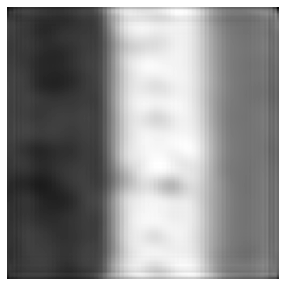

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(pred_new,cmap='gray')
plt.axis('off');

#### Autoencoder on test_set

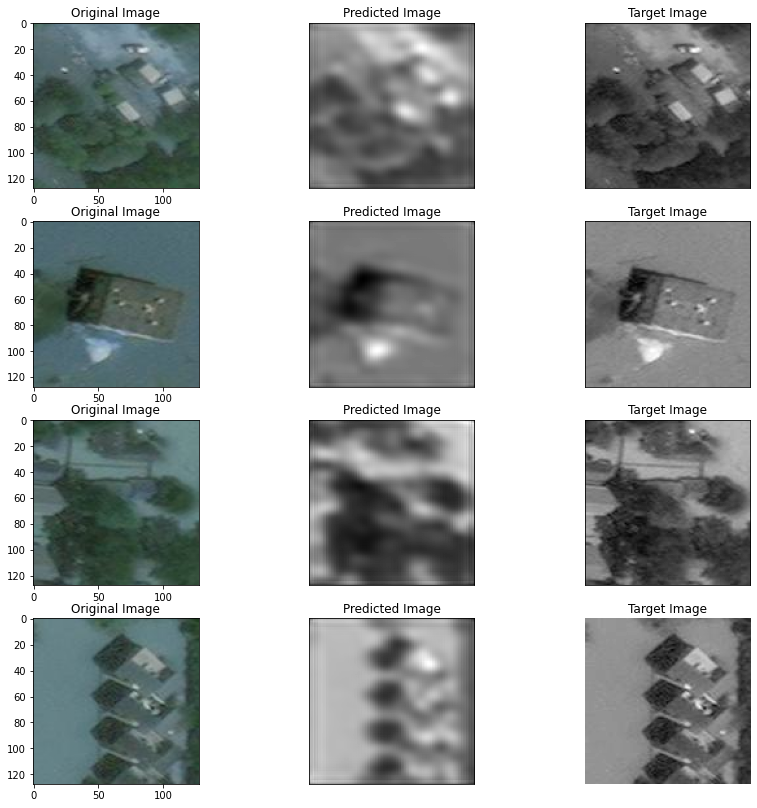

In [ ]:
fig, ax = plt.subplots(4,3,figsize=(14,14))

for i in range(4):
  test_image = np.expand_dims(x_test[i],axis=0)
  pred = model.predict(test_image)
  pred_new = pred.reshape(128,128)

  ax[i,0].imshow(valid_damage_images[i])
  ax[i,0].set_title('Original Image')
  # ax[i,0].set_xticks([])
  # ax[i,0].set_yticks([])

  # pred_image = rot_resize(sample[0][i],-preds[0])
  ax[i,1].imshow(pred_new,cmap='gray')
  ax[i,1].set_title('Predicted Image')
  ax[i,1].set_xticks([])
  ax[i,1].set_yticks([])

  # original_image = rot_resize(sample[0][i],-sample[1][i])# sample[0] is batch of images, we take the first image from it and to acces the lable we use [1]
  ax[i,2].imshow(y_test[i],cmap='gray')
  ax[i,2].set_title('Target Image')
  ax[i,2].set_xticks([])
  ax[i,2].set_yticks([])

plt.axis('off')
plt.show();
